In [1]:
from tensorflow import keras
from tensorflow.keras.callbacks import CSVLogger,ModelCheckpoint

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import copy
import cv2
import os
from PIL import Image

In [29]:
(ds_train , ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split = ['train', 'test'],
    shuffle_files = True,
    with_info = True
)

In [5]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    }),
})

## Base_model Resnet50

In [30]:
num_classes = ds_info.features["label"].num_classes

## pre_train 된 모델 대신 stanford_dogs 데이터에 대한 가중치를 업데이트
base_model = keras.applications.resnet50.ResNet50(
    include_top = False,
    weights = 'imagenet',
    input_shape = (224,224,3),
    pooling = 'avg' # GAP 사용
)

In [31]:
x = base_model.output
preds = keras.layers.Dense(num_classes, 'softmax')(x)
cam_model = keras.Model(inputs = base_model.input, outputs = preds)

In [20]:
cam_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [32]:
def normalize_and_resize_img(input):
    image = tf.image.resize(input['image'], [224,224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

In [33]:
def apply_normalize_on_dataset(ds, is_test = False, batch_size = 16):
    ds = ds.map(
        normalize_and_resize_img,
        num_parallel_calls = 2
    )
    ds = ds.batch(batch_size)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [34]:
ds_train_normal = apply_normalize_on_dataset(ds_train, is_test =False)
ds_val_normal = apply_normalize_on_dataset(ds_test, is_test = True)

In [35]:
for input in ds_train_normal.take(1):
    image, label = input
    print(image.shape)
    print(label.shape)

(16, 224, 224, 3)
(16,)


In [36]:
cam_model.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer = tf.keras.optimizers.SGD(learning_rate = 0.01),
    metrics = ['accuracy']
)

In [37]:
csv_logger = CSVLogger('./pretrain_cam_model_history.csv', append=True)
checkpoint = ModelCheckpoint(  'pretrain_cam_model{epoch:02d}.h5',  
                                save_weights_only=True,  # 가중치만 저장
                                save_freq='epoch',       # 매 에폭마다 저장
                                verbose=1               
                            )

In [38]:
history_cam_model = cam_model.fit(
    ds_train_normal,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs= 10,
    validation_data=ds_val_normal,
    verbose=1,
    use_multiprocessing=True,
    callbacks = [checkpoint,csv_logger]
)

Epoch 1/10
750/750 [==============================] - 160s 207ms/step - loss: 2.2807 - accuracy: 0.4264 - val_loss: 3.2104 - val_accuracy: 0.2326

Epoch 00001: saving model to pretrain_cam_model01.h5
Epoch 2/10
750/750 [==============================] - 155s 206ms/step - loss: 0.6512 - accuracy: 0.8267 - val_loss: 1.2773 - val_accuracy: 0.6326

Epoch 00002: saving model to pretrain_cam_model02.h5
Epoch 3/10
750/750 [==============================] - 155s 206ms/step - loss: 0.1766 - accuracy: 0.9729 - val_loss: 1.0937 - val_accuracy: 0.6865

Epoch 00003: saving model to pretrain_cam_model03.h5
Epoch 4/10
750/750 [==============================] - 155s 207ms/step - loss: 0.0584 - accuracy: 0.9963 - val_loss: 1.0169 - val_accuracy: 0.7091

Epoch 00004: saving model to pretrain_cam_model04.h5
Epoch 5/10
750/750 [==============================] - 155s 206ms/step - loss: 0.0286 - accuracy: 0.9989 - val_loss: 0.9928 - val_accuracy: 0.7218

Epoch 00005: saving model to pretrain_cam_model05.h5


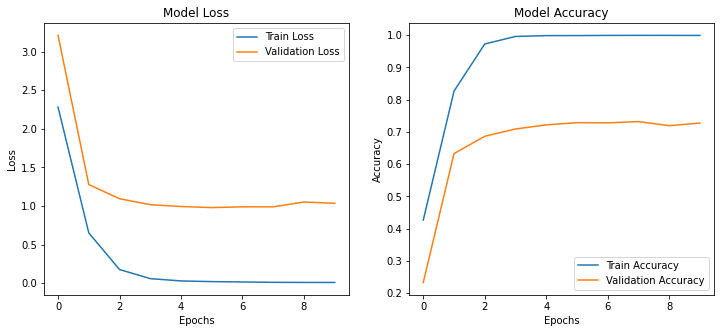

In [147]:
# 학습 이력에서 loss 및 accuracy 데이터 추출
history = history_cam_model.history

# 손실(loss) 그래프
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')

# 정확도(accuracy) 그래프
plt.subplot(1, 2, 2)
plt.plot(history['accuracy'], label='Train Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# 그래프 출력
plt.show()


In [39]:
cam_model_path = os.path.join('./model', 'cam_model1.h5')


cam_model.save(cam_model_path) 

/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


- 최적 지점을 찾아봐야겠다. 
    validation 데이터의 패턴이 train 데이터의 패턴보다 더 복잡해서 정확도의 gap의 크게 나왔다. 
    
    train data를 validation 데이터 셋에 맞춰야겠다.
 
- 모델 변경
    drop out
    
    

In [231]:

(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

def normalize_and_resize_img(input):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    '''
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    '''
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [232]:
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['objects']['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]

11


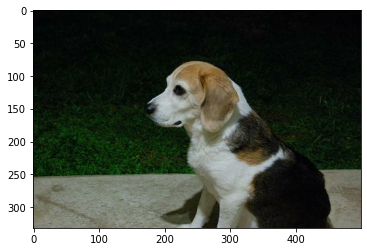

In [233]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

In [234]:
cam_model_path = './model/cam_model1.h5'  # 경로를 직접 문자열로 입력
cam_model = tf.keras.models.load_model(cam_model_path)


## CAM

In [235]:
def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # 학습한 모델에서 원하는 Layer의 output을 얻기 위해서 모델의 input과 output을 새롭게 정의해줍니다.
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    conv_outputs = conv_outputs[0, :, :, :]
    
    # 모델의 weight activation은 마지막 layer에 있습니다.
    class_weights = model.layers[-1].get_weights()[0] 
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        # conv_outputs의 i번째 채널과 i번째 weight를 곱해서 누적하면 활성화된 정도가 나타날 겁니다.
        cam_image += w * conv_outputs[:, :, i]

    cam_image /= np.max(cam_image) # activation score를 normalize합니다.
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height)) # 원래 이미지의 크기로 resize합니다.
    return cam_image

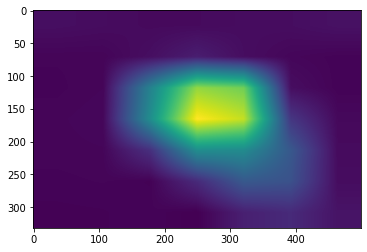

In [236]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

In [237]:
def visualize_cam_on_image(image, cam_image,alpha=0.5):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(image, alpha, cam_image, beta, 0.0)
    return merged_image

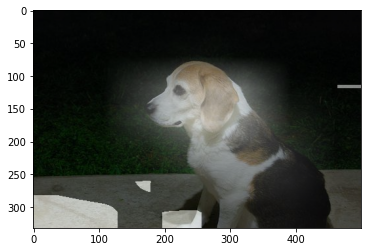

In [238]:
type(item['image'])  

origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

## GRAD_CAM

In [239]:
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    grad_model = tf.keras.models.Model([model.inputs],[model.get_layer(activation_layer).output, model.output])
    
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))

        loss = pred[:, class_idx]
        output = conv_output[0]
        grad_val = tape.gradient(loss, conv_output)[0]
        
    weights = np.mean(grad_val, axis=(0,1))
    grad_cam_image = np.zeros(dtype = np.float32, shape = conv_output.shape[0:2])
    for k, w in enumerate(weights):
        grad_cam_image += w * output[:, :, k]
    
    grad_cam_image = tf.math.maximum(0, grad_cam_image)
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image

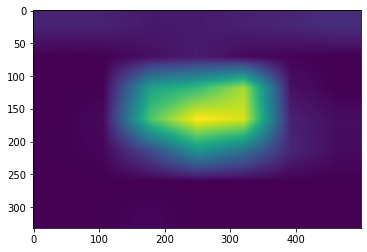

In [240]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

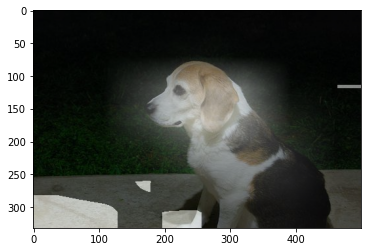

In [241]:
type(item['image'])  

origin_image = item['image'].astype(np.uint8)
grad_cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(grad_cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

## CAM BBOX , IOU

In [242]:
def get_cam_bbox(cam_image, score_thresh=0.5):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect

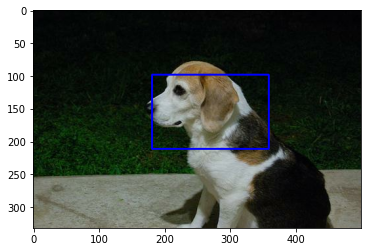

In [243]:
rect = get_cam_bbox(cam_image)
rect
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

In [244]:
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),  #bounding box의 y_min
        rect[:,0].min()/float(image.shape[1]),  #bounding box의 x_min
        rect[:,1].max()/float(image.shape[0]), #bounding box의 y_max
        rect[:,0].max()/float(image.shape[1]) #bounding box의 x_max
    ]
    return bbox

In [245]:
pred_bbox = rect_to_minmax(rect, item['image'])
pred_bbox

[0.29518072289156627, 0.362, 0.6355421686746988, 0.718]

In [246]:
item['objects']['bbox']

array([[0.22289157, 0.326     , 0.9909639 , 0.916     ]], dtype=float32)

In [247]:
## 2개의 좌표를 통해서 horization , vertex 부분을 구함 
def get_iou(gt_bbox, pred_bbox):
    y_min = max(gt_bbox[0], pred_bbox[0])
    x_min= max(gt_bbox[1], pred_bbox[1])
    y_max = min(gt_bbox[2], pred_bbox[2])
    x_max = min(gt_bbox[3], pred_bbox[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    gt_bboxArea = (gt_bbox[2] - gt_bbox[0]) * (gt_bbox[3] - gt_bbox[1])
    pred_bboxArea = (pred_bbox[2] - pred_bbox[0]) * (pred_bbox[3] - pred_bbox[1])
    iou = interArea / float(gt_bboxArea + pred_bboxArea - interArea)

    return iou

In [249]:
get_iou(pred_bbox, item['objects']['bbox'][0])

0.26738448401737613

## GRAD CAM BBOX  IOU

In [250]:
def get_grad_cam_bbox(grad_cam_image, score_thresh=0.5):
    low_indicies = grad_cam_image <= score_thresh
    grad_cam_image[low_indicies] = 0
    grad_cam_image = (grad_cam_image*255).astype(np.uint8)
    
    contours,_ = cv2.findContours(grad_cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect

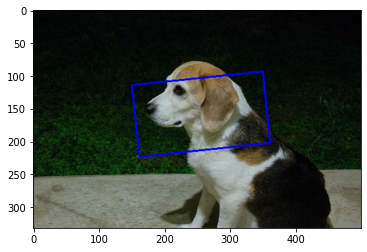

In [251]:
rect = get_grad_cam_bbox(grad_cam_image)
rect
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

In [252]:
pred_bbox = rect_to_minmax(rect, item['image'])
pred_bbox

[0.28012048192771083, 0.3, 0.6716867469879518, 0.722]

In [253]:
item['objects']['bbox']

array([[0.22289157, 0.326     , 0.9909639 , 0.916     ]], dtype=float32)

In [254]:
get_iou(pred_bbox, item['objects']['bbox'][0])

0.3346550975093346

## 결과 

두 개의 클래스가 있을 경우, IoU 값을 계산할 때 threshold를 0.05로 낮게 설정해야 결과가 도출됩니다. 이 경우, CAM의 성능이 GRAD-CAM보다 0.05 이상 높게 나오는 경향이 있다.

이미지마다 CAM과 GRAD-CAM의 성능 차이가 나타나며, 특히 train 데이터와 val 데이터 간의 성능 차이가 크게 발생했습니다. 모델이 train 데이터와 유사한 이미지에서 더 잘 학습되었기 때문에, 그 결과 train 데이터와 유사한 이미지에서는 GRAD-CAM의 성능이 더 좋게 나왔다.

- CAM은 전역적인 특징을 강조하여, 이미지의 전체적인 정보가 명확하게 드러날 때 유리하다.
- GRAD-CAM은 지역적인 특징에 중점을 두고, 모델이 특정 클래스를 인식하는 데 중요한 미세한 요소를 포착하는 데 더 효과적이다.


## 실험 결과

CAM은 이미지의 전반적인 특징을 강조하여 클래스의 전체적인 영역을 포함하는 bounding box를 형성합니다. 이는 종종 CAM에서 GRAD-CAM보다 넓은 bounding box가 생성되는 이유이다..

반면, GRAD-CAM은 이미지의 엣지나 빠르게 변화하는 지역적 특징에 집중합니다. 그 결과, bounding box는 CAM보다 작아지는 경향이 있으며, 더 미세한 부분을 포착한다.

예를 들어, 강아지의 얼굴을 관찰하는 실험에서 CAM은 강아지의 전체 얼굴을 포함하는 bounding box를 생성한 반면, GRAD-CAM은 강아지 얼굴의 울퉁불퉁한 세부적인 부분에 집중한 더 작은 bounding box를 형성했다.

GRAD-CAM이 일부 상황에서 더 나은 성능을 보였지만, 항상 그렇지는 않았다.



## 회고

모델을 학습 할 때 train 정확도와 val 정확도의 폭이 심하게 났는데 이 문제를 해결하기 위해서 data augumentation을 통해 train 데이터가 가지고 있는 pattern들을 다양하게 만들어 validation 데이터 pattern에 맞추도록 만들어봐야겠다. 
